In [1]:
# library for ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data manipulation libraries
import numpy as np
import pandas as pd

# library for interacting with operating system
import os

# data visualization library
from matplotlib import pyplot as plt

# library for splitting data
from sklearn.model_selection import train_test_split

# libraries for creating sequential models and use of layers and different optimizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, MaxPooling2D, BatchNormalization, Flatten
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# library for opening and manipulate images
from PIL import Image

# library for display random image
import random

Using TensorFlow backend.


In [2]:
# some default constants
train_dir = r"C:\Users\Gundeep Gulati\Desktop\dogs-vs-cats\train/"
test_dir = r"C:\Users\Gundeep Gulati\Desktop\dogs-vs-cats\test1/"
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNEL = 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32
epochs = 8

In [3]:
# prepare data and store in dataframe based on category
train = os.listdir(train_dir)
categories = []
for filename in train:
    category = filename.split(".")[0]
    if category == "dog":
        categories.append(category)
    else:
        categories.append(category)


In [4]:
# store data in a dataframe
df = pd.DataFrame({
    "filename" : train,
    "category" : categories
})

In [5]:
# display top 5 rows of dataframe
df.head(5)

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [6]:
# display last 5 rows of dataframe
df.tail()

,filename,category
24995,dog.9995.jpg,dog
24996,dog.9996.jpg,dog
24997,dog.9997.jpg,dog
24998,dog.9998.jpg,dog
24999,dog.9999.jpg,dog


In [7]:
# count number of values based on category feature
df['category'].value_counts()

dog    12500
cat    12500
Name: category, dtype: int64

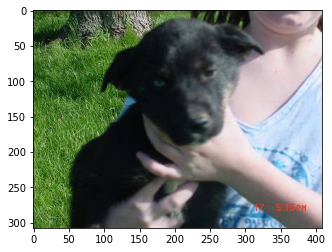

In [8]:
# display random image from dataset
sample_img = random.choice(df.filename)
img = load_img(train_dir+sample_img)
plt.imshow(img)

In [9]:
# splitting the data into train and validation set
train_data, validation_data = train_test_split(df,test_size=0.2,random_state=42)
train_data=train_data.reset_index(drop=True) # reset index of train data
validation_data=validation_data.reset_index(drop=True) # reset index of validation data

In [10]:
train_data['category'].value_counts()

dog    10015
cat     9985
Name: category, dtype: int64

In [11]:
validation_data['category'].value_counts()

cat    2515
dog    2485
Name: category, dtype: int64

In [12]:
# check the shape of train data:-20000 rows 2 columns
train_data.shape

(20000, 2)

In [13]:
# check the shape of validation data:-5000 rows 2 columns
validation_data.shape

(5000, 2)

In [14]:
# perform data augmentation on train data with different techniques like rotation, rescale, shear, horizontal flip, vertical flip
train_datagen = ImageDataGenerator(
                                    rotation_range=30,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
                                    train_data,
                                    train_dir,
                                    x_col='filename',
                                    y_col='category',
                                    target_size= IMG_SIZE,
                                    class_mode = 'binary',
                                    batch_size=batch_size,
                                    shuffle=True)

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
# perform data augmentation on validatipn data with rescale only
validation_datagen = ImageDataGenerator(
rescale=1./255)

validation_generator=validation_datagen.flow_from_dataframe(
validation_data,
train_dir,
    x_col='filename',
    y_col='category',
    target_size= IMG_SIZE,
    class_mode = 'binary',
    batch_size=batch_size,
    shuffle=True
)

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
#model 
model = Sequential()

# convolution layer 1
model.add(Conv2D(32, 3,input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

# convolution layer 2
model.add(Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

# convolution layer 3
model.add(Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

# Flatten layer
model.add(Flatten())

# fully connected layer 1
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))

## Output Layer
model.add(Dense(1, activation = 'sigmoid'))

# optimizer and loss
# used of loss-: binary cross entropy because it is binary classification problem and we have 2 classes
# Adam optimizer is used with learning rate 0.0001 which gives good results on classification problem and converges fastly as per the problem
model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.0001, decay=1e-6) , metrics = ['accuracy'])

# summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)      

In [17]:
# EarlyStopping and ReduceLROnPlateau is used as callbacks to monitor validation accuracy and how it changes per epoch
# if validation accuracy is not improving in 10 epochs it will stop there 
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [18]:
# here we fit our model in which we pass augmented data (Train and Validation) for train the model and also pass number of epochs and callbacks method
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/8
625/625 [==============================] - 345s 551ms/step - loss: 0.8159 - accuracy: 0.6639 - val_loss: 0.7369 - val_accuracy: 0.7148
Epoch 2/8
625/625 [==============================] - 319s 511ms/step - loss: 0.5612 - accuracy: 0.7092 - val_loss: 0.5792 - val_accuracy: 0.7136
Epoch 3/8
625/625 [==============================] - 318s 508ms/step - loss: 0.5269 - accuracy: 0.7373 - val_loss: 0.3537 - val_accuracy: 0.7464
Epoch 4/8
625/625 [==============================] - 330s 528ms/step - loss: 0.5095 - accuracy: 0.7494 - val_loss: 0.3244 - val_accuracy: 0.7572
Epoch 5/8
625/625 [==============================] - 337s 540ms/step - loss: 0.4883 - accuracy: 0.7635 - val_loss: 0.3132 - val_accuracy: 0.7594
Epoch 6/8
625/625 [==============================] - 333s 533ms/step - loss: 0.4784 - accuracy: 0.7758 - val_loss: 0.4032 - val_accuracy: 0.7906
Epoch 7/8
625/625 [==============================] - 342s 547ms/step - loss: 0.4627 - accuracy: 0.7845 - val_loss: 0.1593 - val_ac

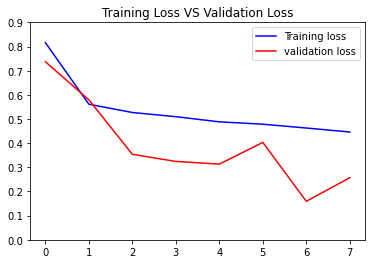

In [19]:
# plot the graph between loss and validation loss
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(0, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.title('Training Loss VS Validation Loss')
plt.show()

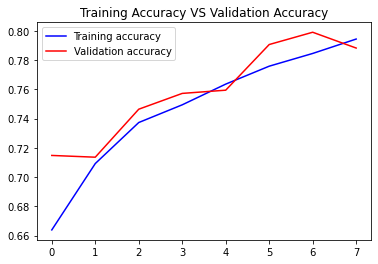

In [20]:
# plot the graph between accuracy and validation accuracy
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(0, epochs, 1))
plt.title('Training Accuracy VS Validation Accuracy')
plt.legend()
plt.show()

In [21]:
# store the test folder images and assign it to dataframe
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [22]:
test_df.head(-5)

,filename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg
...,...
12491,9991.jpg
12492,9992.jpg
12493,9993.jpg
12494,9994.jpg


In [23]:
# rescale the test images using data augmentation
test_datagen=ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_dataframe(
    test_df, 
    test_dir,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMG_SIZE,
    batch_size=32,
    shuffle=False
)

Found 12500 validated image filenames.


In [24]:
# check the number of classes
train_generator.class_indices

{'cat': 0, 'dog': 1}

In [25]:
# here model predict the results on test data
y_pred = model.predict(test_data)

In [26]:
# Here we are assigning 0.5 as a threshold value. If y_pred is greater than 0.5, it belongs to the cat class, and if it is less than 0.5, it belongs to the dog class
y_pred = np.where(y_pred>0.5, "Dog","Cat")

In [27]:
y_pred

array([['Dog'],
       ['Cat'],
       ['Cat'],
       ...,
       ['Dog'],
       ['Cat'],
       ['Cat']], dtype='<U3')

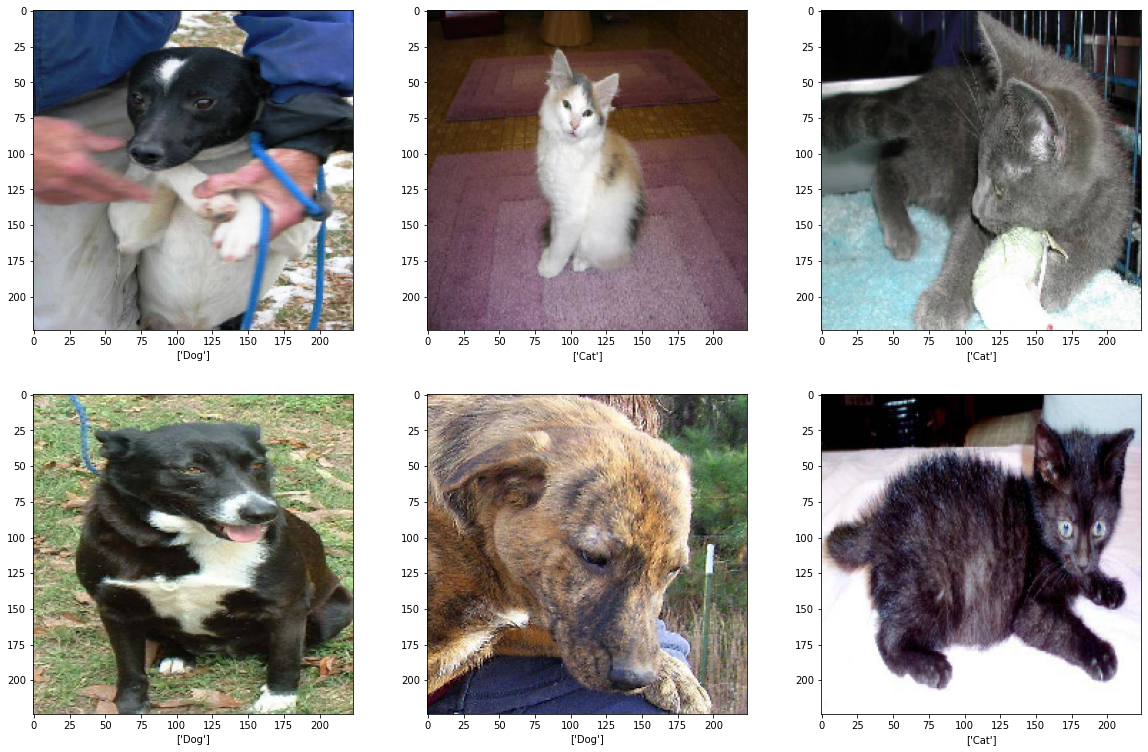

In [28]:
# plot 6 images of cats and dogs on test set
plt.figure(figsize=(20,20))

for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[0][i])
    plt.xlabel(y_pred[i])
plt.show()

In [29]:
# convert labels to 0 and 1
label = np.where(y_pred=="Cat",0,1)

In [30]:
label

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [31]:
# print the accuracy and validation accuracy
print("Train Accuracy:{:.3f}".format(history.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(history.history['val_accuracy'][-1]))

Train Accuracy:0.794
Test Accuracy:0.788
